# Gradient Boost Tree Algorithm

#### Importación de librerías ⬇️

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from imblearn.under_sampling import RandomUnderSampler

random_state = 42
test_size = 0.2

C:\Users\agria\AppData\Local\Temp\ipykernel_23088\667408363.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Importar data general
with open('model.pkl', 'rb') as f:
    generalData = pickle.load(f)

# Importar data de las 10 enfermedades más comunes
with open('model1.pkl', 'rb') as f:
    filteredData = pickle.load(f)

with open('categories.pkl', 'rb') as f:
    categoryData = pickle.load(f)

In [3]:
def preprocessing(df):
    mask = df['PERIODOEDA'] != 3
    df.loc[mask, 'EDAD'] = 1

    freqs = df['DIASESTANCIA'].value_counts()

    df = df.loc[df['DIASESTANCIA'] <= 30]

    # Filter out the rows where the frequency is not equal to 1
    uniques = freqs[freqs == 1].index
    df = df[~df['DIASESTANCIA'].isin(uniques)]

    # Define conditions for categorizing DIASESTANCIA
    conditions = [
        (df['DIASESTANCIA'] < 4),
        (df['DIASESTANCIA'] >= 4)
    ]

    # Define labels for the categories
    labels = [0, 1]

    # Create a new column 'CATDIAS' based on the conditions and labels
    df['CATDIAS'] = np.select(conditions, labels)

    df.pop('PERIODOEDA')

    return df

generalData = preprocessing(generalData)
filteredData = preprocessing(filteredData)
categoryData = preprocessing(categoryData)

#### Funciones de Utilidad

In [4]:
def clfMetrics(clf, X, y):

    y_pred = clf.predict(X)

    # Accuracy
    accuracy = accuracy_score(y, y_pred)

    # Precision
    precision = precision_score(y, y_pred, average='micro')

    # Recall
    recall = recall_score(y, y_pred, average='micro')

    # F1 Score
    f1 = f1_score(y, y_pred, average='micro')

    # Confusion Matrix
    confusionMatrix = confusion_matrix(y, y_pred)

    # Initializing ConfusionMatrixDisplay with the confusion matrix
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)

    fig, ax = plt.subplots(figsize=(10,10))

    # Plotting the confusion matrix
    cmDisplay.plot(ax=ax)
    plt.title('Matriz de Confusión de Modelo Clasificador')
    plt.show()

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [5]:
def estMetrics(est, X, y):

    y_pred = est.predict(X)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, y_pred)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, y_pred)

    # Calculate R-squared (R^2)
    r2 = r2_score(y, y_pred)

    # Print the metrics
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R^2): {r2:.4f}")

## Modelos Respecto al Conjunto de Datos Original, con Histogram Gradient Boosting

### Modelo de Regresión

#### Separación de Conjunto de Datos

Dado que el conjunto de datos cuenta con 2,382,742 entradas, el tamaño asignado al conjunto de pruebas no será de gran importancia, ya que siempre se tendrán cantidades significativas de datos. Sin embargo, es importante tener en cuenta que este conjunto de datos no está balanceado, ya que hay muchas entradas que corresponden a enfermedades comunes, mientras que hay pocas para enfermedades menos comunes. Este desequilibrio puede causar problemas si se utiliza un split aleatorio, ya que existe la posibilidad de que tanto el conjunto de entrenamiento como el de prueba no contengan cantidades significativas de ciertas clases de datos.

Para abordar este problema, se realizará un split estratificado, además de emplear una librería que provea las funciones necesarias para asegurar que los conjuntos de datos se mantengan balanceados.

Se realizará el mismo proceso de separación de datos para los modelos subsecuentes.

In [6]:
df_cp = generalData.copy()

df_cp.pop('MUNIRESIDEN')
df_cp.pop('AÑO')
df_cp.pop('MES')
df_cp.pop('CLUSTER')
df_cp.pop('CATDIAS')

# Separate the target variable 'DIASESTANCIA' into y and the rest of the DataFrame into X
y = df_cp.pop('DIASESTANCIA')
X = df_cp

print(X.shape)
print(y.shape)

(2372, 6)
(2372,)


In [7]:
# Stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

print(X_train.shape)
print(y_train.shape)

(1897, 6)
(1897,)


#### Primera Iteración de Modelo de Regresión

In [8]:
est = HistGradientBoostingRegressor(random_state=random_state)
est.fit(X_train, y_train)

HistGradientBoostingRegressor(random_state=42)

In [9]:
print("Performance Metrics on Test Set:")
estMetrics(est, X_test, y_test)

print("\nPerformance Metrics on Train Set:")
estMetrics(est, X_train, y_train)

Performance Metrics on Test Set:
Mean Absolute Error (MAE): 1.0154
R-squared (R^2): -0.1156

Performance Metrics on Train Set:
Mean Absolute Error (MAE): 0.7294
R-squared (R^2): 0.5267


#### Segunda Iteración con Ajuste de Hiperparámetros

In [10]:
param_grid = {
    'max_depth': range(5, 16, 5),  # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_iter': [100, 200, 300],  # Maximum number of boosting iterations
    'loss': ['squared_error', 'absolute_error', 'gamma', 'poisson']
}

cv = KFold(n_splits=4, shuffle=True, random_state=random_state)

model = HistGradientBoostingRegressor(random_state=random_state)

est = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    return_train_score=True,
    cv=cv,
).fit(X_train, y_train)

print("Best Parameters:", est.best_params_)

KeyboardInterrupt: 

In [ ]:
print("Performance Metrics on Test Set:")
estMetrics(est, X_test, y_test)

print("\nPerformance Metrics on Train Set:")
estMetrics(est, X_train, y_train)

### Modelo de Clasificación

Explicacion aqui


#### Separación de conjuntos de datos

Explicacion aqui

In [ ]:
df_cp = generalData.copy()

df_cp.pop('MUNIRESIDEN')
df_cp.pop('AÑO')
df_cp.pop('MES')
df_cp.pop('CLUSTER')

df_cp = df_cp.loc[~df_cp['PPERTENENCIA'].isin([9, 5])]
df_cp.pop('DIASESTANCIA')

# Separate the target variable 'DIASESTANCIA' into y and the rest of the DataFrame into X
y = df_cp.pop('CATDIAS')
X = df_cp

In [ ]:
# Stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

rus = RandomUnderSampler(random_state=random_state)
X_balanced, y_balanced = rus.fit_resample(X_train, y_train)

print(X_balanced.shape)
print(y_balanced.shape)

#### Primera Iteración de Modelo de Clasificación

In [ ]:
clf = HistGradientBoostingClassifier(random_state=random_state)
clf.fit(X_train, y_train)

In [ ]:
print("Performance Metrics on Test Set:")
clfMetrics(clf, X_test, y_test)

print("Performance Metrics on Train Set:")
clfMetrics(clf, X_train, y_train)

#### Segunda Iteración con Ajuste de Hiperparámetros

In [ ]:
param_grid = {
    'max_depth': range(5, 16, 5),  # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_iter': [100, 200, 300],  # Maximum number of boosting iterations
}

cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

model = HistGradientBoostingClassifier(random_state=random_state)

clf = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    return_train_score=True,
    cv=cv,
).fit(X_train, y_train)

print("Best Parameters:", clf.best_params_)

In [ ]:
print("Performance Metrics on Test Set:")
clfMetrics(clf, X_test, y_test)

print("Performance Metrics on Train Set:")
clfMetrics(clf, X_train, y_train)

## Modelos Respecto a las 10 Enfermedades Más Comunes, con Histogram Gradient Boosting

### Modelo de Regresión

#### Separación de conjuntos de datos

Este conjunto de datos presenta los mismos predictores que el modelo anterior, por lo tanto, se seguirá la misma estrategia de separación de datos. La distinción entre estos dos conjuntos radica en que uno incluye todas las entradas de todas las enfermedades, mientras que este conjunto se centra más en las enfermedades más comunes. El propósito es evaluar el impacto de la extensa lista de enfermedades según la Clasificación Internacional de Enfermedades (ICD) en comparación con un conjunto más específico de enfermedades.

In [ ]:
df_cp = filteredData.copy()

df_cp.pop('MUNIRESIDEN')
df_cp.pop('AÑO')
df_cp.pop('MES')
df_cp.pop('CLUSTER')
df_cp.pop('CATDIAS')

# Separate the target variable 'DIASESTANCIA' into y and the rest of the DataFrame into X
y = df_cp.pop('DIASESTANCIA')
X = df_cp

print(X.shape)
print(y.shape)

In [ ]:
# Stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

print(X_train.shape)
print(y_train.shape)

(553, 7)
(553,)


#### Primera Iteración de Modelo de Regresión

In [ ]:
est = HistGradientBoostingRegressor(random_state=random_state)
est.fit(X_train, y_train)

In [ ]:
print("Performance Metrics on Test Set:")
estMetrics(est, X_test, y_test)

print("\nPerformance Metrics on Train Set:")
estMetrics(est, X_train, y_train)

Mean Absolute Percentage Error (MAPE): 0.3189
R-squared (R^2): 0.1316


#### Segunda Iteración con Ajuste de Hiperparámetros

In [ ]:
param_grid = {
    'max_depth': range(5, 16, 5),  # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_iter': [100, 200, 300],  # Maximum number of boosting iterations
    'loss': ['squared_error', 'absolute_error', 'gamma', 'poisson']
}

cv = KFold(n_splits=4, shuffle=True, random_state=random_state)

model = HistGradientBoostingRegressor(random_state=random_state)

est = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    return_train_score=True,
    cv=cv,
).fit(X_train, y_train)

print("Best Parameters:", est.best_params_)

In [ ]:
print("Performance Metrics on Test Set:")
estMetrics(est, X_test, y_test)

print("\nPerformance Metrics on Train Set:")
estMetrics(est, X_train, y_train)

### Modelo de Clasificación

#### Separación de conjuntos de datos

In [ ]:
df_cp = filteredData.copy()

df_cp.pop('MUNIRESIDEN')
df_cp.pop('AÑO')
df_cp.pop('MES')
df_cp.pop('CLUSTER')

df_cp = df_cp.loc[~df_cp['PPERTENENCIA'].isin([9, 5])]
df_cp.pop('DIASESTANCIA')

# Separate the target variable 'DIASESTANCIA' into y and the rest of the DataFrame into X
y = df_cp.pop('CATDIAS')
X = df_cp

In [ ]:
# Stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

rus = RandomUnderSampler(random_state=random_state)
X_balanced, y_balanced = rus.fit_resample(X_train, y_train)

print(X_balanced.shape)
print(y_balanced.shape)

#### Primera Iteración de Modelo de Clasificación

In [ ]:
clf = HistGradientBoostingClassifier(random_state=random_state)
clf.fit(X_train, y_train)

In [ ]:
print("Performance Metrics on Test Set:")
clfMetrics(clf, X_test, y_test)

print("Performance Metrics on Train Set:")
clfMetrics(clf, X_train, y_train)

#### Segunda Iteración con Ajuste de Hiperparámetros

In [ ]:
param_grid = {
    'max_depth': range(5, 16, 5),  # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_iter': [100, 200, 300],  # Maximum number of boosting iterations
}

cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

model = HistGradientBoostingClassifier(random_state=random_state)

clf = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    return_train_score=True,
    cv=cv,
).fit(X_train, y_train)

print("Best Parameters:", clf.best_params_)

In [ ]:
print("Performance Metrics on Test Set:")
clfMetrics(clf, X_test, y_test)

print("Performance Metrics on Train Set:")
clfMetrics(clf, X_train, y_train)

## Modelos Respecto al Conjunto de Datos Original con Enfermedades Categorizadas, con Histogram Gradient Boosting

Explicacion aqui

### Modelo de Regresión

#### Separación del conjunto de datos

Explicacion aqui

In [14]:
df_cp = categoryData.copy()

df_cp.pop('MUNIRESIDEN')
df_cp.pop('AÑO')
df_cp.pop('MES')
df_cp.pop('CATDIAS')

df_cp = df_cp.loc[~df_cp['PPERTENENCIA'].isin([9, 5])]
df_cp = df_cp.loc[df_cp['CAUFIN'] < 3000]

# Drop 'CAUFIN' as it is redundant with respect to 'ICDCAT'
#df_cp.pop('CAUFIN')

# Separate the target variable 'DIASESTANCIA' into y and the rest of the DataFrame into X
y = df_cp.pop('DIASESTANCIA')
X = df_cp

print(X.shape)
print(y.shape)

(1546190, 7)
(1546190,)


In [15]:
# Stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

rus = RandomUnderSampler(random_state=random_state)
X_balanced, y_balanced = rus.fit_resample(X_train, y_train)

print(X_balanced.shape)
print(y_balanced.shape)

(11160, 7)
(11160,)


#### Primera Iteración de Modelo de Regresión

In [16]:
est = HistGradientBoostingRegressor(random_state=random_state)
est.fit(X_train, y_train)

HistGradientBoostingRegressor(random_state=42)

In [17]:
print("Performance Metrics on Test Set:")
estMetrics(est, X_test, y_test)

print("\nPerformance Metrics on Train Set:")
estMetrics(est, X_train, y_train)

Performance Metrics on Test Set:
Mean Squared Error (MSE): 4.4468
Mean Absolute Error (MAE): 0.9453
R-squared (R^2): 0.1199

Performance Metrics on Train Set:
Mean Squared Error (MSE): 4.4238
Mean Absolute Error (MAE): 0.9442
R-squared (R^2): 0.1244


#### Segunda Iteración con Ajuste de Hiperparámetros

In [ ]:
param_grid = {
    'max_depth': range(5, 16, 5),  # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_iter': [100, 200, 300],  # Maximum number of boosting iterations
    'loss': ['squared_error', 'absolute_error', 'gamma', 'poisson']
}

cv = KFold(n_splits=4, shuffle=True, random_state=random_state)

model = HistGradientBoostingRegressor(random_state=random_state)

est = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    return_train_score=True,
    cv=cv,
).fit(X_train, y_train)

print("Best Parameters:", est.best_params_)

In [ ]:
print("Performance Metrics on Test Set:")
estMetrics(est, X_test, y_test)

print("\nPerformance Metrics on Train Set:")
estMetrics(est, X_train, y_train)

### Modelo de Clasificación

#### Separación del conjunto de datos

In [10]:
df_cp = categoryData.copy()

df_cp.pop('DIASESTANCIA')
df_cp.pop('MUNIRESIDEN')
df_cp.pop('AÑO')
df_cp.pop('MES')

df_cp = df_cp.loc[~df_cp['PPERTENENCIA'].isin([9, 5])]
df_cp = df_cp.loc[df_cp['CAUFIN'] < 3000]

# Drop 'CAUFIN' as it is redundant with respect to 'ICDCAT'
df_cp.pop('CAUFIN')

# Separate the target variable 'CATDIAS' into y and the rest of the DataFrame into X
y = df_cp.pop('CATDIAS')
X = df_cp

print(X.shape)
print(y.shape)

(1546190, 6)
(1546190,)


In [11]:
# Stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

rus = RandomUnderSampler(random_state=random_state)
X_balanced, y_balanced = rus.fit_resample(X_train, y_train)

print(X_balanced.shape)
print(y_balanced.shape)

(185590, 6)
(185590,)


#### Primera Iteración de Modelo de Clasificación

In [12]:
clf = HistGradientBoostingClassifier(random_state=random_state)
clf.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=42)

Performance Metrics on Test Set:


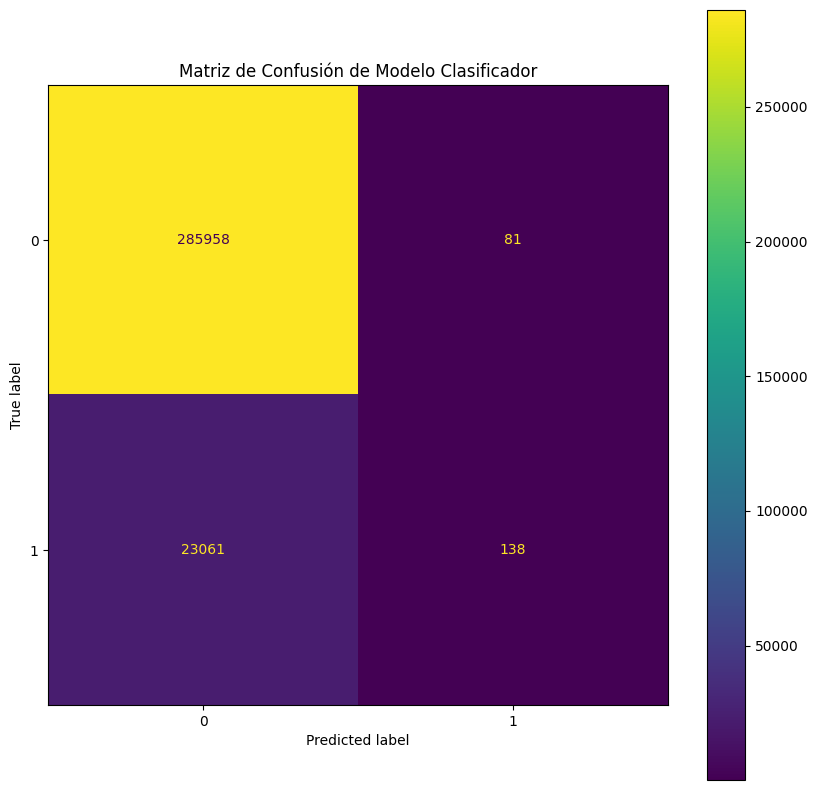

Accuracy: 0.925164436453476
Precision: 0.925164436453476
Recall: 0.925164436453476
F1 Score: 0.925164436453476
Performance Metrics on Train Set:


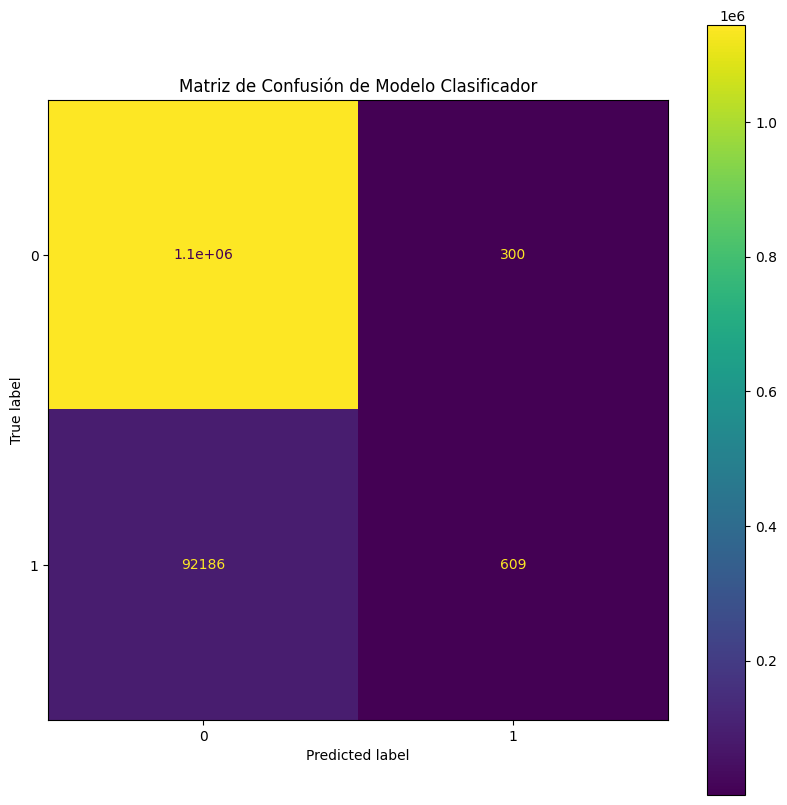

Accuracy: 0.9252307284357032
Precision: 0.9252307284357032
Recall: 0.9252307284357032
F1 Score: 0.9252307284357032


In [13]:
print("Performance Metrics on Test Set:")
clfMetrics(clf, X_test, y_test)

print("Performance Metrics on Train Set:")
clfMetrics(clf, X_train, y_train)

#### Segunda Iteración con Ajuste de Hiperparámetros

In [ ]:
param_grid = {
    'max_depth': range(5, 16, 5),  # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_iter': [100, 200, 300],  # Maximum number of boosting iterations
}

cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

model = HistGradientBoostingClassifier(random_state=random_state)

clf = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    return_train_score=True,
    cv=cv,
).fit(X_train, y_train)

print("Best Parameters:", clf.best_params_)

In [ ]:
print("Performance Metrics on Test Set:")
clfMetrics(clf, X_test, y_test)

print("Performance Metrics on Train Set:")
clfMetrics(clf, X_train, y_train)